In [225]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [226]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error,mean_squared_error,r2_score
import tensorflow as tf
from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense,LSTM,Reshape,Dropout

In [227]:
# assign path
path, dirs, files = next(os.walk("/content/drive/MyDrive/weatherdata_for_students/"))
file_count = len(files)
# create empty list
dataframes_list = []
dataframes_brigton_list =[]
# append datasets to the list

for i in range(file_count):
    if(files[i].startswith('brighton')):
      temp_brighton_df = pd.read_csv("/content/drive/MyDrive/weatherdata_for_students/"+files[i])
      if '0' in temp_brighton_df.columns:
        temp_brighton_df = pd.read_csv("/content/drive/MyDrive/weatherdata_for_students/"+files[i], header=1)
      dataframes_brigton_list.append(temp_brighton_df)
brighton_weather_df=pd.concat(dataframes_brigton_list)


In [228]:
brighton_weather_df.set_index(pd.to_datetime(brighton_weather_df['datetime']),inplace=True)
brighton_weather_df.drop('datetime',axis=1,inplace=True)
brighton_weather_df.sort_index(ascending=True,inplace=True)

In [229]:
train_df = pd.read_csv('/content/drive/MyDrive/weatherdata_for_students/train_new.csv')
val_df = pd.read_csv('/content/drive/MyDrive/weatherdata_for_students/val_new.csv')
test_df = pd.read_csv('/content/drive/MyDrive/weatherdata_for_students/test_new.csv')

In [230]:
#Converting Date column as Index

train_df.set_index(pd.to_datetime(train_df['date']),inplace=True)
train_df.drop('date',axis=1,inplace=True)
train_df.sort_index(ascending=True,inplace=True)
val_df.set_index(pd.to_datetime(val_df['date']),inplace=True)
val_df.drop('date',axis=1,inplace=True)
val_df.sort_index(ascending=True,inplace=True)
test_df.set_index(pd.to_datetime(test_df['date']),inplace=True)
test_df.drop('date',axis=1,inplace=True)
test_df.sort_index(ascending=True,inplace=True)

In [231]:
#Functions to calculate MAE and MMAPE and R2 Score

def measure_mean_absolute_percentage_error(label,forcast):
    label=np.array(label)
    forcast=np.array(forcast)
    non_zero_label = label != 0
    label = label[non_zero_label]
    forcast = forcast[non_zero_label]
    return np.mean(np.abs(label-forcast)/label) * 100


def measure_forecast_error(label, forecast):
    '''We will use this function to measure the performance of our baseline models'''
    print('MAE = %.2f ' % mean_absolute_error(label, forecast))
    print('MAPE = %.2f%%' % measure_mean_absolute_percentage_error(label, forecast))
    print('R2 = %.2f' % r2_score(label, forecast))

## Baseline

Creating a logical Baseline by just comparing the data from the previous years to the validation data as we saw that the data is Cyclic in nature and also has seasonality thoughtout the year and daily in case of solar energy

MAE = 9.29 
MAPE = 98.99%
R2 = -0.89


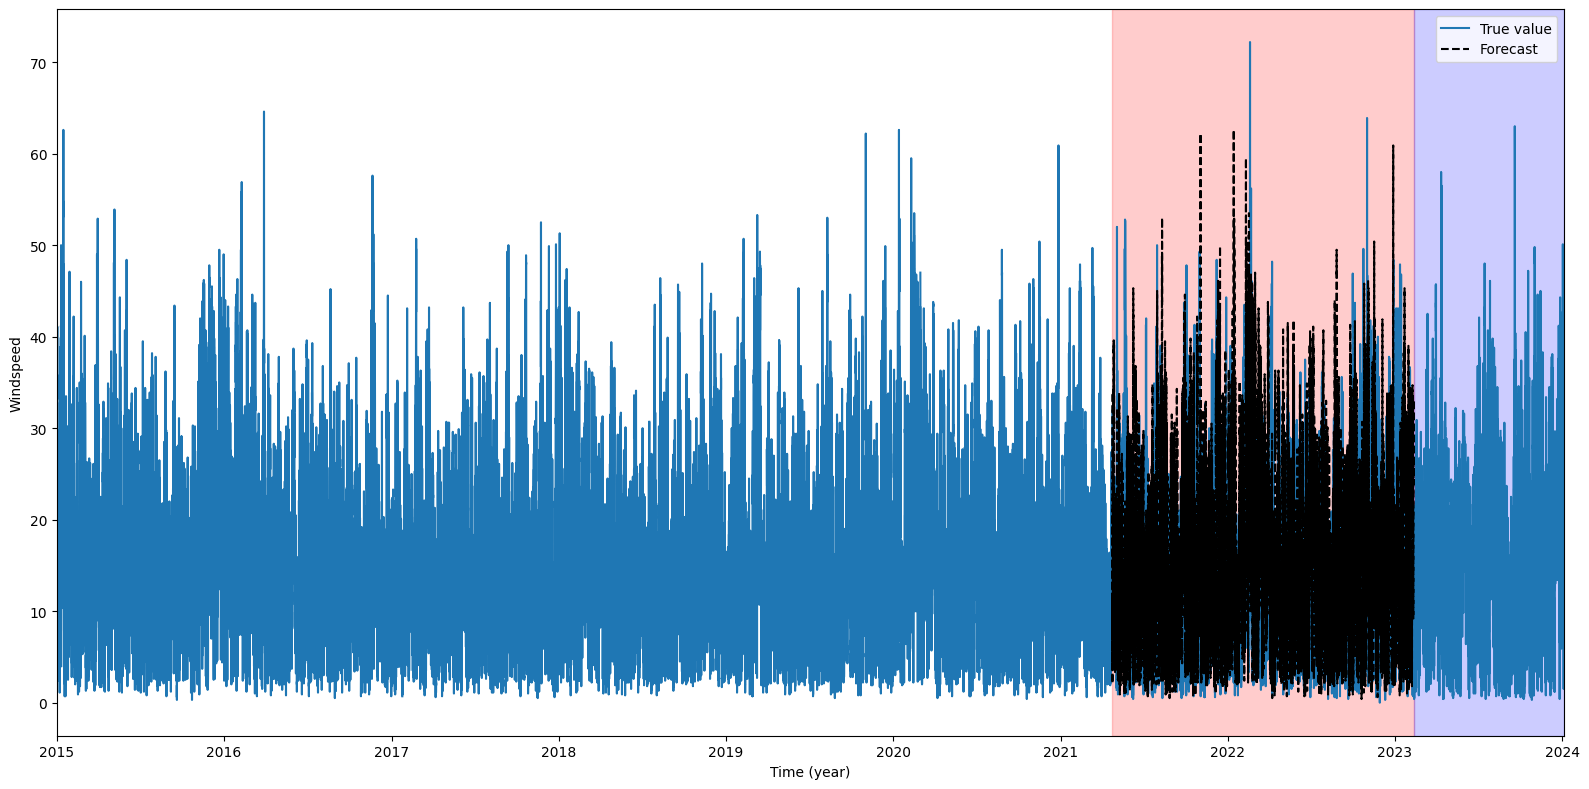

In [232]:
val_df['baseline_last_period_wind'] = train_df.loc['2019-04-23 10:00:00':'2021-02-09 19:00:00']['windspeed'].values

measure_forecast_error(val_df['windspeed'], val_df['baseline_last_period_wind'])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(brighton_weather_df.index, brighton_weather_df['windspeed'], label='True value')
ax.plot(val_df.index, val_df['baseline_last_period_wind'], '--', color='k', label='Forecast')
ax.axvspan(val_df.index.min(), val_df.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test_df.index.min(), test_df.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Windspeed')
_=ax.set_xlim(train_df.index.min(), test_df.index.max())
plt.legend(loc='best')
plt.tight_layout()

MAE = 0.23 
MAPE = 80.71%
R2 = 0.55


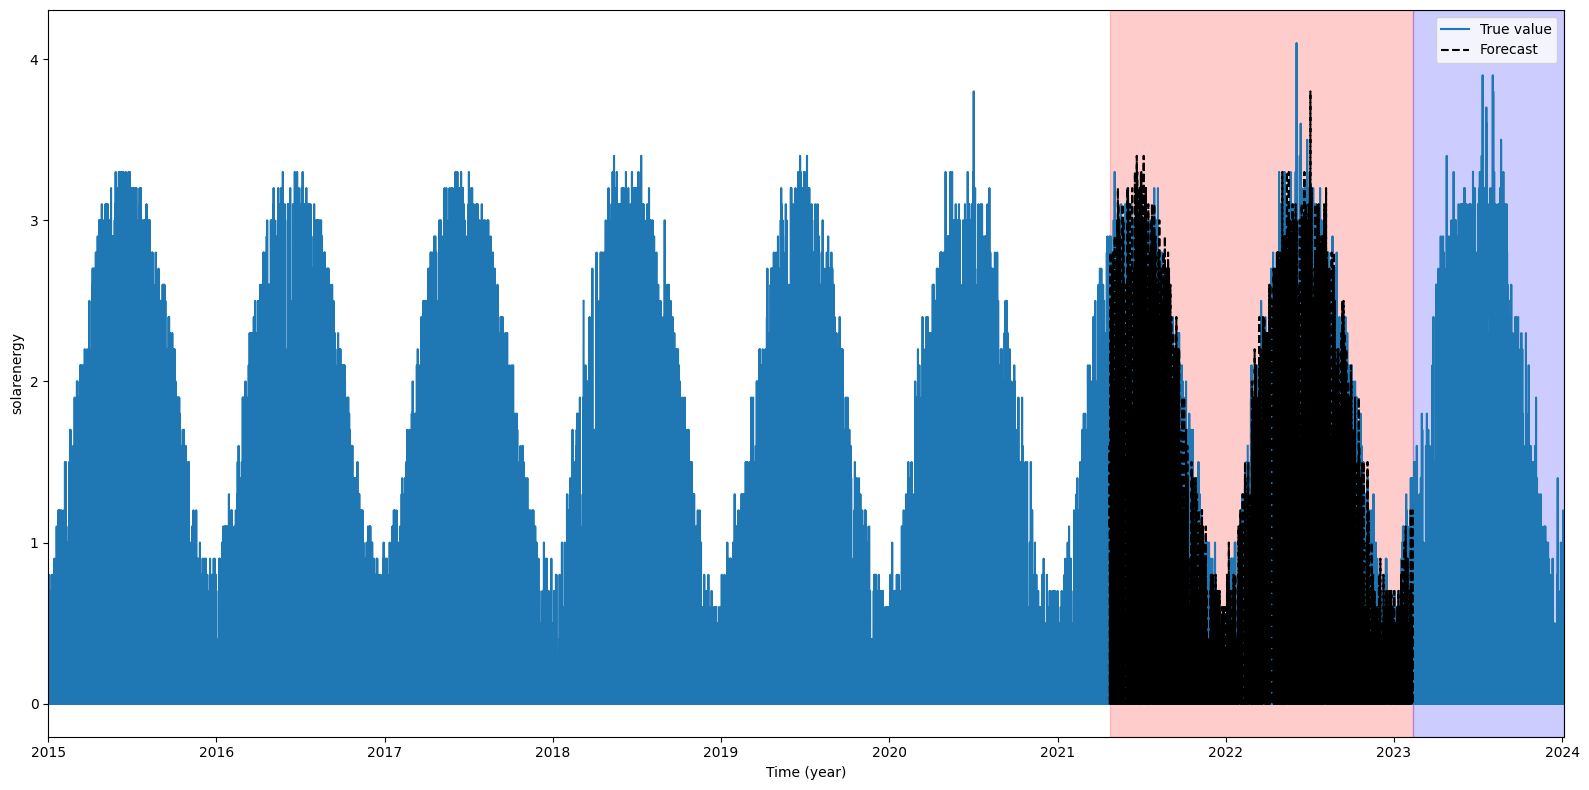

In [233]:

val_df['baseline_last_period_solar'] = train_df.loc['2019-04-23 10:00:00':'2021-02-09 19:00:00']['solarenergy'].values

measure_forecast_error(val_df['solarenergy'], val_df['baseline_last_period_solar'])

fig, ax = plt.subplots(figsize=(16,8))
ax.plot(brighton_weather_df.index, brighton_weather_df['solarenergy'], label='True value')
ax.plot(val_df.index, val_df['baseline_last_period_solar'], '--', color='k', label='Forecast')
ax.axvspan(val_df.index.min(), val_df.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test_df.index.min(), test_df.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('solarenergy')
_=ax.set_xlim(train_df.index.min(), test_df.index.max())
plt.legend(loc='best')
plt.tight_layout()

In [234]:
#Reindexing data frame from Date to normal Index

train_df.reset_index(inplace=True)
# Removing the current index and converting it into a column
val_df.reset_index(inplace=True)
# Removing the current index and converting it into a column
test_df.reset_index(inplace=True)



##Data Prepration

In [235]:
#Converting Time to Sine and Cosine for as model will not all String Inputs

timestamp_s = pd.to_datetime(train_df['date']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60

train_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
train_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
train_df.drop(columns='date',inplace=True)

timestamp_s = pd.to_datetime(val_df['date']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60

val_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
val_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
val_df.drop(columns='date',inplace=True)

timestamp_s = pd.to_datetime(test_df['date']).map(datetime.datetime.timestamp)
day = 24 * 60 * 60

test_df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
test_df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
test_df.drop(columns='date',inplace=True)

In [236]:
val_df.drop(columns=['baseline_last_period_solar','baseline_last_period_wind'],inplace=True)

In [237]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,55306.0,10.957554,5.620594,-5.90,7.100000,1.070000e+01,15.100000,32.800
humidity,55306.0,82.569864,12.666342,26.99,75.120000,8.546500e+01,92.630000,100.000
precip,55306.0,0.076774,0.672529,0.00,0.000000,0.000000e+00,0.000000,27.086
precipprob,55306.0,6.518280,24.685037,0.00,0.000000,0.000000e+00,0.000000,100.000
windspeed,55306.0,16.148503,9.040125,0.30,9.500000,1.450000e+01,21.800000,64.600
sealevelpressure,55306.0,1015.964311,10.608931,971.20,1010.100000,1.017100e+03,1023.000000,1049.300
solarenergy,55306.0,0.485428,0.783266,0.00,0.000000,0.000000e+00,0.700000,3.800
uvindex,55306.0,1.330724,2.192077,0.00,0.000000,0.000000e+00,2.000000,10.000
day_sin,55306.0,0.000124,0.707122,-1.00,-0.707107,1.421321e-14,0.707107,1.000
day_cos,55306.0,0.000051,0.707104,-1.00,-0.707107,1.570693e-14,0.707107,1.000


In [238]:
y_scaler = MinMaxScaler()

# Extract the values of the specified columns
y_values = train_df[['windspeed', 'solarenergy']].values

# Fit the scaler on the values
y_scaler.fit(y_values)

# Transform the values
scaled_y_values = y_scaler.transform(y_values)

scaled_y_values.shape

# Extract the values of the specified columns
y_values_val = val_df[['windspeed', 'solarenergy']].values

scaled_y_values = y_scaler.transform(y_values_val)

scaled_y_values.shape

(15802, 2)

In [239]:
scaler = MinMaxScaler()
scaler.fit(train_df)

train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])




##Modeling

In [240]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Initialize the DataWindow object with necessary parameters and dataframes

        # Store training, validation, and testing dataframes
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Store label columns and their indices if provided
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        # Store column indices for all columns in the training dataframe
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Set input width, label width, and shift for the window
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        # Calculate total window size
        self.total_window_size = input_width + shift

        # Define slices for input and label indices
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    #functional call
    def split_to_inputs_labels(self, features):
        # Split features into inputs and labels

        # Extract input and label sequences
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]

        # If label columns are specified, stack them accordingly
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )

        # Set shapes for inputs and labels
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='solarenergy', max_subplots=3):
        # Plot inputs, labels, and predictions (if available)

        # Retrieve a sample batch from the training dataset
        inputs, labels = self.sample_batch

        # Create the plot
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        # Plot for each sample in the batch
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')

            # Plot inputs
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            # Plot labels
            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is not None:
                plt.scatter(self.label_indices, labels[n, :, label_col_index],
                            edgecolors='k', marker='s', label='Labels', c='green', s=64)

            # Plot predictions if model is provided
            if model is not None:
                predictions = model(inputs)

                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                            marker='X', edgecolors='k', label='Predictions',
                            c='red', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time (h)')


    def make_dataset(self, data):
        # Create a tf.data.Dataset from the provided data

        # Convert data to numpy array
        data = np.array(data, dtype=np.float32)

        # Create time series dataset from array
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        # Map the dataset to split inputs and labels
        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        # Return a dataset for training
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        # Return a dataset for validation
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        # Return a dataset for testing
        return self.make_dataset(self.test_df)


    @property
    def sample_batch(self):
        # Return a sample batch from the training dataset

        # Get the cached sample batch if available, otherwise get a new one
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [241]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

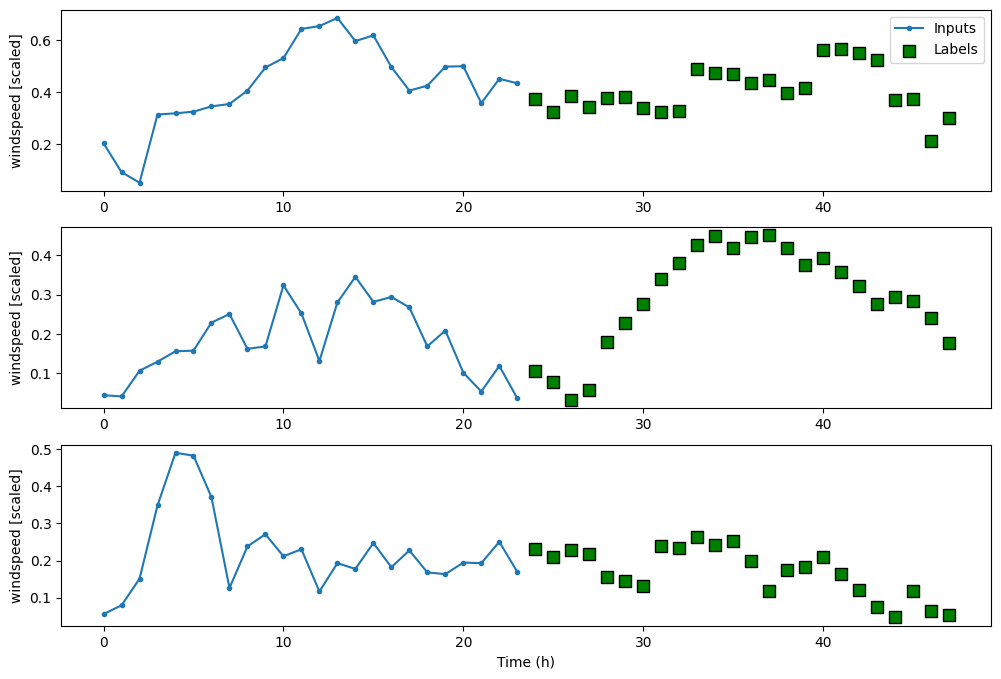

In [242]:
#This indicates that we take a window of 24 hours to predict the data 24 hours in future
wide_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['windspeed','solarenergy'])
wide_window.plot(plot_col='windspeed')

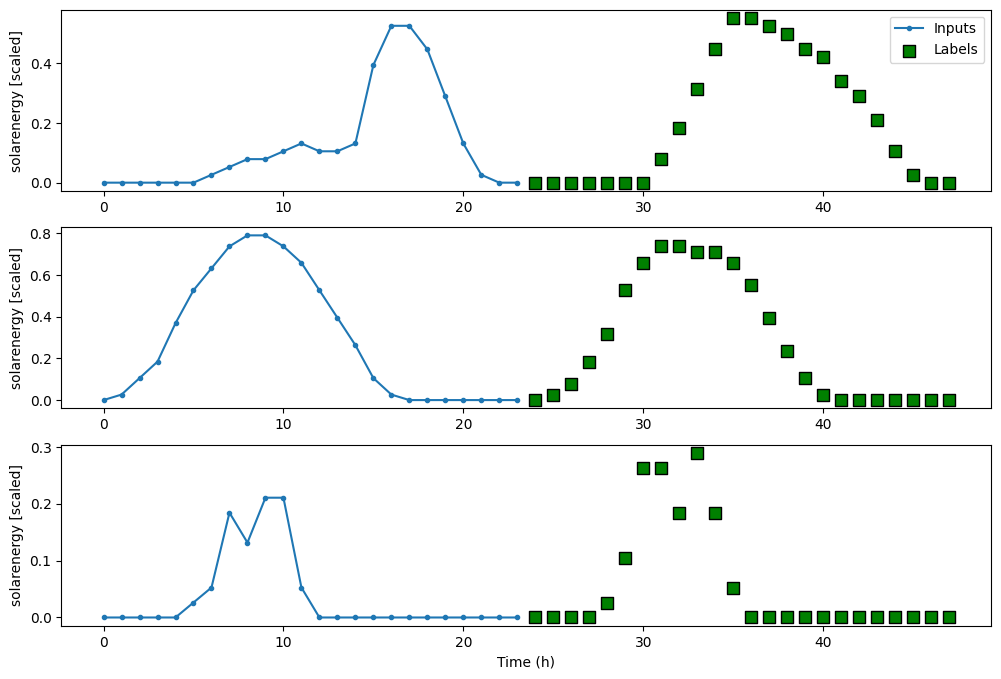

In [243]:
wide_window.plot()

In [244]:
lstm_model = Sequential([
    LSTM(52, return_sequences=True ,recurrent_dropout=0.25),
    Dense(units = 2)
])
history = compile_and_fit(lstm_model, wide_window)
val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
1727/1727 [==============================] - 74s 41ms/step - loss: 0.0137 - mean_absolute_error: 0.0810 - val_loss: 0.0128 - val_mean_absolute_error: 0.0771
Epoch 2/50
1727/1727 [==============================] - 78s 45ms/step - loss: 0.0126 - mean_absolute_error: 0.0768 - val_loss: 0.0124 - val_mean_absolute_error: 0.0748
Epoch 3/50
1727/1727 [==============================] - 71s 41ms/step - loss: 0.0124 - mean_absolute_error: 0.0758 - val_loss: 0.0123 - val_mean_absolute_error: 0.0732
Epoch 4/50
1727/1727 [==============================] - 67s 39ms/step - loss: 0.0123 - mean_absolute_error: 0.0750 - val_loss: 0.0122 - val_mean_absolute_error: 0.0733
Epoch 5/50
1727/1727 [==============================] - 67s 39ms/step - loss: 0.0122 - mean_absolute_error: 0.0746 - val_loss: 0.0123 - val_mean_absolute_error: 0.0735
Epoch 6/50
1727/1727 [==============================] - 67s 39ms/step - loss: 0.0120 - mean_absolute_error: 0.0741 - val_loss: 0.0120 - val_mean_absolute_error:

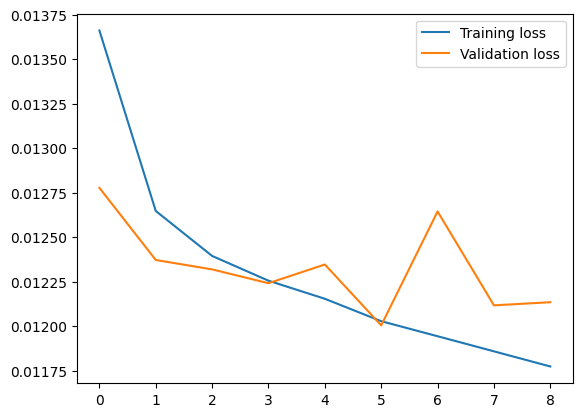

In [245]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

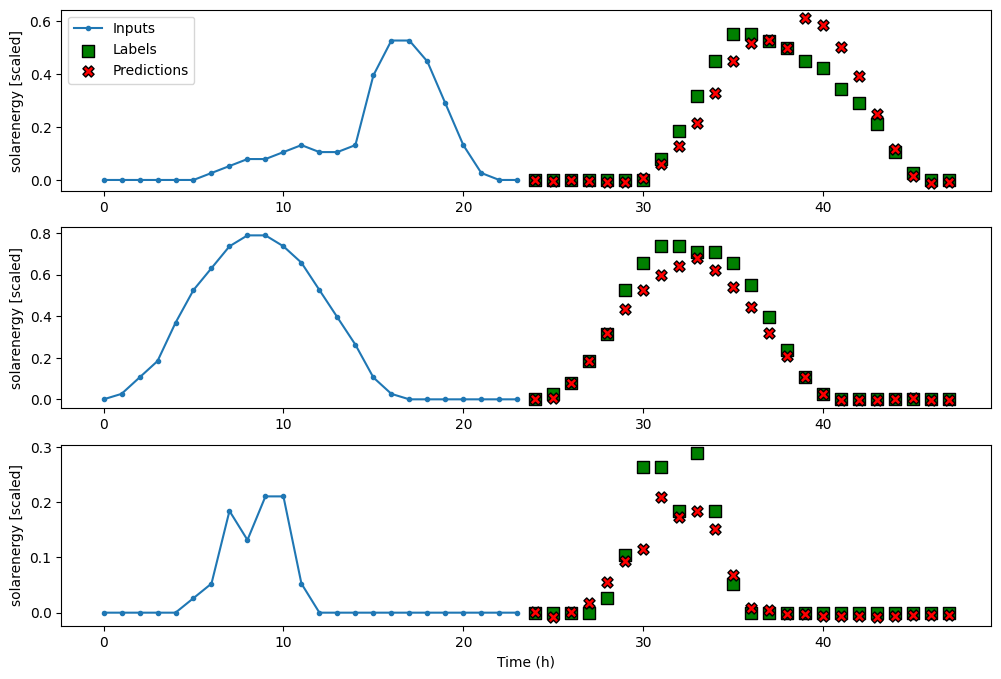

In [246]:
wide_window.plot(lstm_model)

Model was able to predit Solar Energy well but didnot preform well with Wind Energy.As we also saw while exploring the data that Wind is eratic in nature and hence difficult to predict.

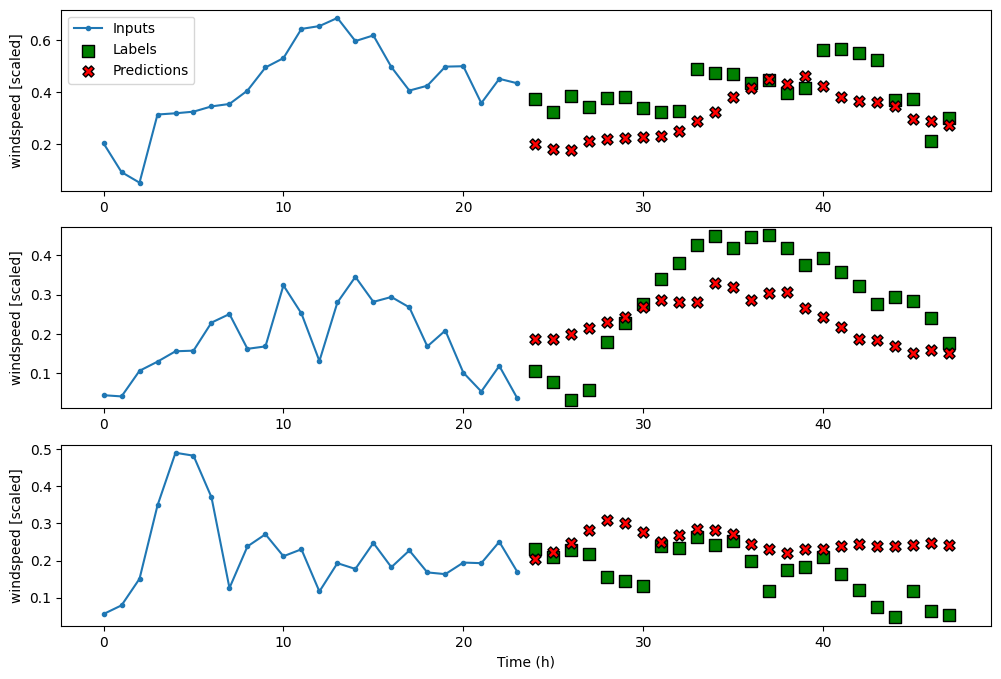

In [247]:
wide_window.plot(lstm_model,plot_col='windspeed')

In [248]:
test_predictions=lstm_model.predict(wide_window.test)

246/246 [==============================] - 4s 13ms/step


In [249]:
test_predictions.shape

(7854, 24, 2)

In [250]:
test_predictions = test_predictions.reshape(7854, -1)[:, :2]

In [259]:
test_predictions.shape

(7854, 2)

##Research

https://www.brighton-hove.gov.uk/files/sites/bhconnected/files/2011%20Census%20Briefing%20-%20City%20Profile.pdf

https://www.utilitybidder.co.uk/compare-business-energy/what-is-the-average-household-energy-usage/

This article states that the average energy consumtion in Uk household is between 8.5-10kWh per day.

Suppose We have 100000 houses in Brighton and cosuming 10 KWH of electricity in day on an average This will help me get the average Electricity per day as 1000000 KWH

The standard(link is external) density of air is 1.225 kg/m3
The turbine has a 24 m diameter, which means the radius is 12 m. Thus, the swept area of the turbine is: (pi)r2 = 3.14159(122) = 452.4 m2
assume a common value for the power coefficient, typically around 0.35, and use a standard air density (ρ) of approximately 1.225 kg/m^3 at sea level and 15°C.

reference for the formula https://www.e-education.psu.edu/emsc297/node/649


Number of wind mills was taken from below Reference:
https://rampionoffshorewindfarm.co.uk/key-facts/#:~:text=The%20Rampion%20Offshore%20Wind%20Farm,foundation%20fixed%20into%20the%20seabed.


Energy Consumption Per hour 41666.66 KHW for 100000 houses

Surplus Energy Calculations considering 4 time the normal Consumptions:
166666 KWH

In [252]:
train_df[train_df.columns] = scaler.inverse_transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.inverse_transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.inverse_transform(test_df[test_df.columns])


In [253]:
#Let's assume a solar panel efficiency of 17% (0.17) and consider the conversion for one hour of sunlight
#So, to convert solar energy from MJ/m^2 to kW, you would multiply by approximately 0.04722
#onsidering 5000 solar panels and 116 Wind mills in Brighton for Train data we had 3672 instances where we had Surplus Energy

surplus=train_df.loc[:,['solarenergy','windspeed']][round((train_df['solarenergy']*0.04722),2)*5000+round(((np.power((train_df['windspeed']/3.6),3))*0.5*1.225*452.4)/116,2)*100>166666].count()

In [254]:
#Let's assume a solar panel efficiency of 17% (0.17) and consider the conversion for one hour of sunlight
#So, to convert solar energy from MJ/m^2 to kW, you would multiply by approximately 0.04722
#Considering 5000 solar panels and 116 Wind mills in Brighton for Test data we had 502 instances where we had Surplus Energy

surplus+=val_df.loc[:,['solarenergy','windspeed']][(round((val_df['solarenergy']*0.04722),2)*5000)+(round(((np.power((val_df['windspeed']/3.6),3))*0.5*1.225*452.4)/116,2)*100)>166666].count()

In [255]:
#Let's assume a solar panel efficiency of 17% (0.17) and consider the conversion for one hour of sunlight
#So, to convert solar energy from MJ/m^2 to kW, you would multiply by approximately 0.04722
#Considering 5000 solar panels and 116 Wind mills in Brighton for Test data we had 502 instances where we had Surplus Energy

surplus+=test_df.loc[:,['solarenergy','windspeed']][(round((test_df['solarenergy']*0.04722),2)*5000)+(round(((np.power((test_df['windspeed']/3.6),3))*0.5*1.225*452.4)/116,2)*100)>166666].count()

In [256]:
# We had surplus instances in the data form 2015 till 2024 Jan
surplus

solarenergy    4686
windspeed      4686
dtype: int64